In [1]:
%matplotlib inline
import requests
from datetime import datetime
from matplotlib import pyplot as plt
from IPython.display import display, HTML
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from numba import guvectorize
from scipy import signal
from scipy import stats as ss

In [2]:
# utils functions
# ===============

def get_prices(coin_symbol):
    """Get close price.

    Given a symbol crytocurrency retrieve last 2k close prices in USD.

    Parameters
    ----------
    coin_symbol : str

    Returns
    -------
    price_close : pandas.DataFrame
    """
    endpoint = "https://min-api.cryptocompare.com/data/histoday"
    params = dict(fsym=coin_symbol, tsym="USD",limit=2000, aggregate=1)
    out = requests.get(endpoint, params=params).json()['Data']
    data = pd.DataFrame(out).set_index('time')\
                            .loc[:, ['close']]\
                            .rename(columns=dict(close=coin_symbol))
    return data

In [3]:
def get_symbol_close(coin_symbol_list):
    """Get symbol close.

    Given a list of cryptocurrencies symbols retrieve close prices.

    Parameters
    ----------
    coin_symbol_list : list

    Returns
    -------
    price_close : pandas.DataFrame
    """
    d = [get_prices(coin_sym) for coin_sym in coin_symbol_list]
    out = pd.concat(d, axis=1)
    out.index = out.index.map(datetime.utcfromtimestamp)
    return out.asfreq(out.index.inferred_freq)


def multi_column_df_display(list_dfs, cols=3):
    html_table = "<table style='width:100%; border:0px'>{content}</table>"
    html_row = "<tr style='border:0px'>{content}</tr>"
    html_cell = "<td style='width:{width}%;vertical-align:top;border:0px'>{{content}}</td>"
    html_cell = html_cell.format(width=100/cols)
    cells = [html_cell.format(content=df.to_html()) for df in list_dfs]
    cells += (cols - (len(list_dfs) % cols)) * [html_cell.format(content="")]
    rows = [html_row.format(content="".join(cells[i:i+cols])) for i in range(0, len(cells), cols)]
    display(HTML(html_table.format(content="".join(rows))))

In [4]:
# hurst functions
# ===============
@guvectorize("float64[:], int64, int64, int64, float64[:]", "(m),(),(),()->()",
             cache=True, nopython=True)
def hurst_rs(x, min_chunksize, max_chunksize, num_chunksize, out):
    """Estimate the Hurst exponent using R/S method.

    Estimates the Hurst (H) exponent using the R/S method from the time series.
    The R/S method consists of dividing the series into pieces of equal size
    `series_len` and calculating the rescaled range. This repeats the process
    for several `series_len` values and adjusts data regression to obtain the H.
    `series_len` will take values between `min_chunksize` and `max_chunksize`,
    the step size from `min_chunksize` to `max_chunksize` can be controlled
    through the parameter `step_chunksize`.

    Parameters
    ----------
    x : 1D-array
        A time series to calculate hurst exponent, must have more elements
        than `min_chunksize` and `max_chunksize`.
    min_chunksize : int
        This parameter allow you control the minimum window size.
    max_chunksize : int
        This parameter allow you control the maximum window size.
    num_chunksize : int
        This parameter allow you control the size of the step from minimum to
        maximum window size. Bigger step means fewer calculations.
    out : 1-element-array, optional
        one element array to store the output.

    Returns
    -------
    H : float
        A estimation of Hurst exponent.

    References
    ----------
    Hurst, H. E. (1951). Long term storage capacity of reservoirs. ASCE
    Transactions, 116(776), 770-808.
    Alessio, E., Carbone, A., Castelli, G. et al. Eur. Phys. J. B (2002) 27:
    197. http://dx.doi.org/10.1140/epjb/e20020150
    """
    N = len(x)
    max_chunksize += 1
    rs_tmp = np.empty(N, dtype=np.float64)
    chunk_size_list = np.linspace(min_chunksize, max_chunksize, num_chunksize)\
                        .astype(np.int64)
    rs_values_list = np.empty(num_chunksize, dtype=np.float64)

    # 1. The series is divided into chunks of chunk_size_list size
    for i in range(num_chunksize):
        chunk_size = chunk_size_list[i]

        # 2. it iterates on the indices of the first observation of each chunk
        number_of_chunks = int(len(x) / chunk_size)

        for idx in range(number_of_chunks):
            # next means no overlapping
            # convert index to index selection of each chunk
            ini = idx * chunk_size
            end = ini + chunk_size
            chunk = x[ini:end]

            # 2.1 Calculate the RS (chunk_size)
            z = np.cumsum(chunk - np.mean(chunk))
            rs_tmp[idx] = np.divide(
                np.max(z) - np.min(z),  # range
                np.nanstd(chunk)  # standar deviation
            )

        # 3. Average of RS(chunk_size)
        rs_values_list[i] = np.nanmean(rs_tmp[:idx + 1])

    # 4. calculate the Hurst exponent.
    H, c = np.linalg.lstsq(
        a=np.vstack((np.log(chunk_size_list), np.ones(num_chunksize))).T,
        b=np.log(rs_values_list)
    )[0]

    out[0] = H

In [5]:
def hurst_dma(prices, min_chunksize=8, max_chunksize=200, num_chunksize=5):
    """Estimate the Hurst exponent using R/S method.

    Estimates the Hurst (H) exponent using the DMA method from the time series.
    The DMA method consists on calculate the moving average of size `series_len`
    and subtract it to the original series and calculating the standard
    deviation of that result. This repeats the process for several `series_len`
    values and adjusts data regression to obtain the H. `series_len` will take
    values between `min_chunksize` and `max_chunksize`, the step size from
    `min_chunksize` to `max_chunksize` can be controlled through the parameter
    `step_chunksize`.

    Parameters
    ----------
    prices
    min_chunksize
    max_chunksize
    num_chunksize

    Returns
    -------
    hurst_exponent : float
        Estimation of hurst exponent.

    References
    ----------
    Alessio, E., Carbone, A., Castelli, G. et al. Eur. Phys. J. B (2002) 27:
    197. http://dx.doi.org/10.1140/epjb/e20020150

    """
    max_chunksize += 1
    N = len(prices)
    n_list = np.arange(min_chunksize, max_chunksize, num_chunksize, dtype=np.int64)
    dma_list = np.empty(len(n_list))
    factor = 1 / (N - max_chunksize)
    # sweeping n_list
    for i, n in enumerate(n_list):
        b = np.divide([n - 1] + (n - 1) * [-1], n)  # do the same as:  y - y_ma_n
        noise = np.power(signal.lfilter(b, 1, prices)[max_chunksize:], 2)
        dma_list[i] = np.sqrt(factor * np.sum(noise))

    H, const = np.linalg.lstsq(
        a=np.vstack([np.log10(n_list), np.ones(len(n_list))]).T,
        b=np.log10(dma_list)
    )[0]
    return H

In [6]:
def hurst_dsod(x):
    """Estimate Hurst exponent on data timeseries.

    The estimation is based on the discrete second order derivative. Consists on
    get two different noise of the original series and calculate the standard
    deviation and calculate the slope of two point with that values.
    source: https://gist.github.com/wmvanvliet/d883c3fe1402c7ced6fc

    Parameters
    ----------
    x : numpy array
        time series to estimate the Hurst exponent for.

    Returns
    -------
    h : float
        The estimation of the Hurst exponent for the given time series.

    References
    ----------
    Istas, J.; G. Lang (1994), “Quadratic variations and estimation of the local
    Hölder index of data Gaussian process,” Ann. Inst. Poincaré, 33, pp. 407–436.


    Notes
    -----
    This hurst_ets is data literal traduction of wfbmesti.m of waveleet toolbox
    from matlab.
    """
    y = np.cumsum(np.diff(x, axis=0), axis=0)

    # second order derivative
    b1 = [1, -2, 1]
    y1 = signal.lfilter(b1, 1, y, axis=0)
    y1 = y1[len(b1) - 1:]  # first values contain filter artifacts

    # wider second order derivative
    b2 = [1,  0, -2, 0, 1]
    y2 = signal.lfilter(b2, 1, y, axis=0)
    y2 = y2[len(b2) - 1:]  # first values contain filter artifacts

    s1 = np.mean(y1 ** 2, axis=0)
    s2 = np.mean(y2 ** 2, axis=0)

    return 0.5 * np.log2(s2 / s1)

In [7]:
def hurst_exponent(prices, min_chunksize=8, max_chunksize=200, num_chunksize=5,
                   method='RS'):
    """Estimates Hurst Exponent.

    Estimate the hurst exponent following one of 3 methods. Each method

    Parameters
    ----------
    prices : numpy.ndarray, pandas.Series or pandas.DataFrame
        A time series to estimate hurst exponent.
    min_chunksize : int, optional
        Minimum chunk  size of the original series. This parameter doesn't have
        any effect with DSOD method.
    max_chunksize : int, optional
        Maximum chunk size of the original series. This parameter doesn't have
        any effect with DSOD method.
    step_chunksize : int, optional
        Step used to select next the chunk size which divide the original
        series. This parameter doesn't have any effect with DSOD method.
    method : {'RS', 'DMA', 'DSOD', 'all'}
        The methods can take one of that values,
            RS : rescaled range.
            DMA : deviation moving average.
            DSOD : discrete second order derivative.


    Returns
    -------
    hurst_exponent : float
        Estimation of hurst_exponent according to the method selected.

    References
    ----------
    RS : Hurst, H. E. (1951). Long term storage capacity of reservoirs. ASCE
         Transactions, 116(776), 770-808.
    DMA : Alessio, E., Carbone, A., Castelli, G. et al. Eur. Phys. J. B (2002)
         27: 197. http://dx.doi.org/10.1140/epjb/e20020150
    DSOD : Istas, J.; G. Lang (1994), “Quadratic variations and estimation of
        the local Hölder index of data Gaussian process,” Ann. Inst. Poincaré,
        33, pp. 407–436.

    Notes
    -----
    The hurst exponent is an estimation which is important because there is no
    data closed equation for it instead we have some methods to estimate it with
    high variations among them.

    See Also
    --------
    hurst_rs, hurst_dma, hurst_dsod
    """
    if len(prices) == 0:
        return np.nan
    # extract array
    arr = prices.__array__()
    # choose data method
    if method == 'RS':
        if prices.ndim > 1:
            h = hurst_rs(np.diff(arr, axis=0).T, min_chunksize, max_chunksize,
                         num_chunksize)
        else:
            h = hurst_rs(np.diff(arr), min_chunksize, max_chunksize,
                         num_chunksize)
    elif method == 'DMA':
        h = hurst_dma(arr, min_chunksize, max_chunksize, num_chunksize)
    elif method == 'DSOD':
        h = hurst_dsod(arr)
    elif method == 'all':
        return [
            hurst_exponent(arr, min_chunksize, max_chunksize, num_chunksize, 'RS'),
            hurst_exponent(arr, min_chunksize, max_chunksize, num_chunksize, 'DMA'),
            hurst_exponent(arr, min_chunksize, max_chunksize, num_chunksize, 'DSOD')
        ]
    else:
        raise NotImplementedError('The method choose is not implemented.')
    
    return h

To show about about persistence we can follow similiar steps as shown in the paper [Persistence in the cryptocurrency market](https://www.sciencedirect.com/science/article/pii/S0275531917309200). I select the same four currencies selected in that paper, that is: Bitcoin, Ethereum, Dash and Litecoin.

You can see [here](https://coinmarketcap.com/coins/) the top crypto currencies by market capitalization.

In [8]:
coin_sym_list = 'BTC ETH DASH LTC'.split()
prices = get_symbol_close(coin_sym_list)
prices = prices.loc['2014':]  # select the same period
prices = prices.where(prices != 0., np.nan)  # convert zeros into NaN's

In [9]:
multi_column_df_display([prices.head(), prices.tail()], 2)

,BTC,ETH,DASH,LTC
time,,,,
2014-01-01,815.94,NaN,NaN,24.77
2014-01-02,856.91,NaN,NaN,26.60
2014-01-03,884.26,NaN,NaN,25.49
2014-01-04,924.69,NaN,NaN,24.05
2014-01-05,1014.74,NaN,NaN,26.01
,BTC,ETH,DASH,LTC
time,,,,
2018-09-24,6583.53,227.92,197.82,57.95
2018-09-25,6437.74,219.20,189.69,57.54


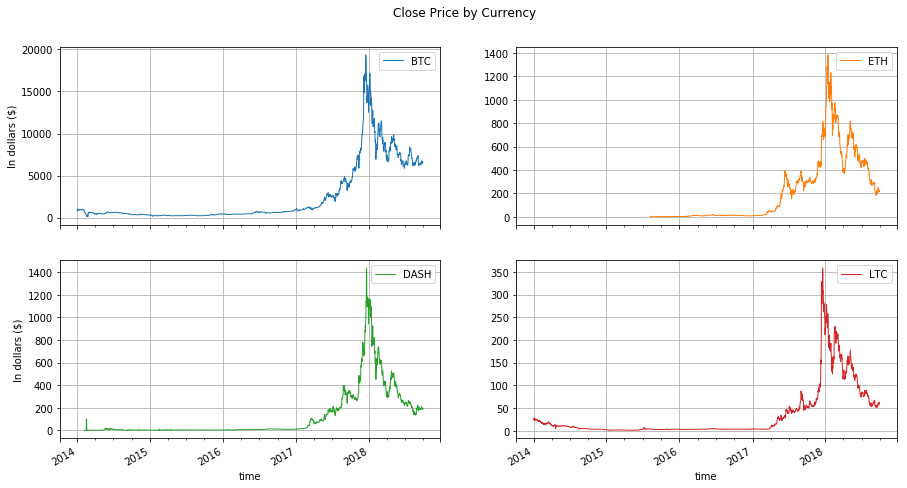

In [10]:
# plot price series
kw = dict(figsize=(15,8), grid=True, subplots=True, layout=(2,2), linewidth=1)
axs = prices.plot(**kw)
[ax.set_ylabel('In dollars ($)') for ax in axs.flat[::2]]
plt.suptitle('Close Price by Currency', y=0.95);

In [11]:
# table hurst with entire series
hurst_methods = [
    prices.apply(lambda x: hurst_exponent(x.dropna(), method='DSOD')),
    prices.apply(lambda x: hurst_exponent(x.dropna(), method='RS')),
    prices.apply(lambda x: hurst_exponent(x.dropna(), method='DMA')),
]
hurst_table = pd.concat(hurst_methods, axis=1)
hurst_table.columns = ['DSOD', 'RS', 'DMA']
hurst_table

/Users/noahmitsuhashi/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in hurst_rs
/Users/noahmitsuhashi/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log10
/Users/noahmitsuhashi/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:44: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


,DSOD,RS,DMA
BTC,0.577284,0.584657,NaN
ETH,0.568265,0.625484,NaN
DASH,0.457117,0.536049,NaN
LTC,0.566743,0.587203,NaN


In [12]:
# the same methodology as shown in the paper.
roll_days = 400
roll_prices = prices.rolling(roll_days)
summary = [
    roll_prices.apply(lambda s: hurst_exponent(s, method='RS')),
    roll_prices.apply(lambda s: hurst_exponent(s, method='DSOD')),
    ]
roll_hurst = pd.concat(summary, axis=1, keys=['RS', 'DSOD'])
roll_hurst = roll_hurst.swaplevel(axis=1)\
                       .asfreq(roll_hurst.index.inferred_freq)\
                       .sort_index(axis=1, level=0)

/Users/noahmitsuhashi/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """
/Users/noahmitsuhashi/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  


In [13]:
roll_hurst[::10].tail()

BTC                DASH                 ETH            \
                DSOD        RS      DSOD        RS      DSOD        RS   
time                                                                     
2018-08-18  0.580500  0.641911  0.444233  0.637791  0.564811  0.633680   
2018-08-28  0.582410  0.643969  0.444729  0.642597  0.569539  0.642103   
2018-09-07  0.582473  0.653575  0.445841  0.645618  0.569661  0.626165   
2018-09-17  0.583420  0.638289  0.445596  0.634113  0.570348  0.640483   
2018-09-27  0.584180  0.636710  0.445115  0.635632  0.570516  0.643868   

                 LTC            
                DSOD        RS  
time                            
2018-08-18  0.570869  0.623125  
2018-08-28  0.571046  0.610578  
2018-09-07  0.570378  0.592763  
2018-09-17  0.570709  0.597666  
2018-09-27  0.571295  0.597789

In [14]:
roll_hurst[::10].mean()

BTC   DSOD    0.570516
      RS      0.593663
DASH  DSOD    0.369686
      RS      0.520739
ETH   DSOD    0.550100
      RS      0.627607
LTC   DSOD    0.513979
      RS      0.569868
dtype: float64

In [15]:
roll_hurst[::10].median()

BTC   DSOD    0.581617
      RS      0.594076
DASH  DSOD    0.448001
      RS      0.507904
ETH   DSOD    0.556591
      RS      0.639221
LTC   DSOD    0.567266
      RS      0.567250
dtype: float64

In [16]:
roll_hurst[::10].mean(level=0, axis=1);

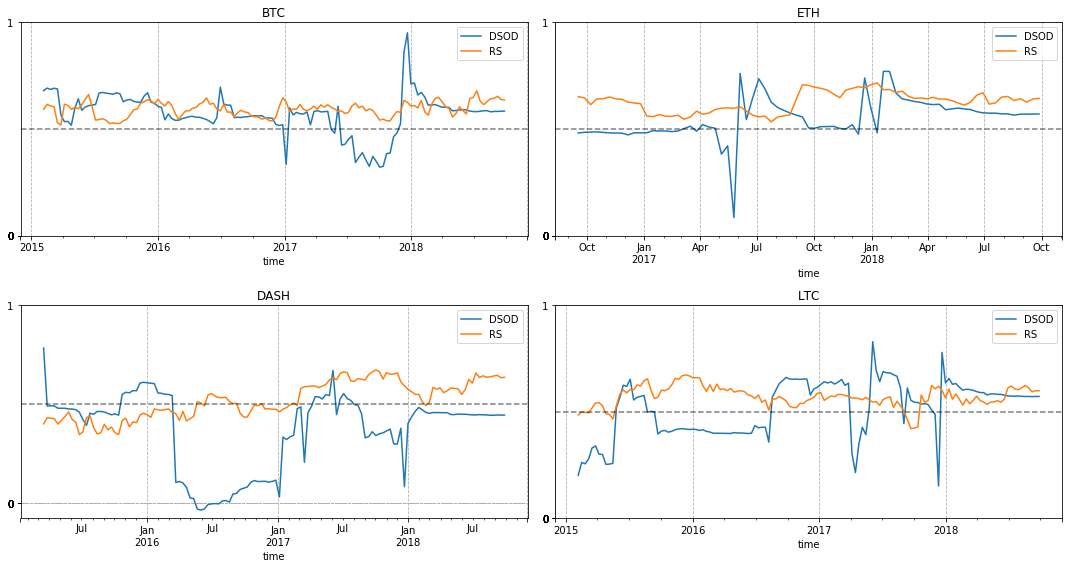

In [17]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin][::10].plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

In [18]:
# rather decimate the series we aliasing the seies.
ma_roll_hurst = roll_hurst.rolling(10).mean()
ma_roll_hurst.tail()

BTC                DASH                 ETH            \
                DSOD        RS      DSOD        RS      DSOD        RS   
time                                                                     
2018-09-24  0.583493  0.632960  0.446106  0.640820  0.569922  0.642529   
2018-09-25  0.583659  0.632406  0.446122  0.639820  0.569973  0.642605   
2018-09-26  0.583738  0.631643  0.446161  0.640660  0.570032  0.643649   
2018-09-27  0.583814  0.631485  0.446113  0.640812  0.570049  0.643988   
2018-09-28  0.583872  0.630667  0.446718  0.640584  0.570117  0.644748   

                 LTC            
                DSOD        RS  
time                            
2018-09-24  0.570763  0.597905  
2018-09-25  0.570891  0.597808  
2018-09-26  0.570973  0.597443  
2018-09-27  0.571031  0.597455  
2018-09-28  0.571129  0.596358

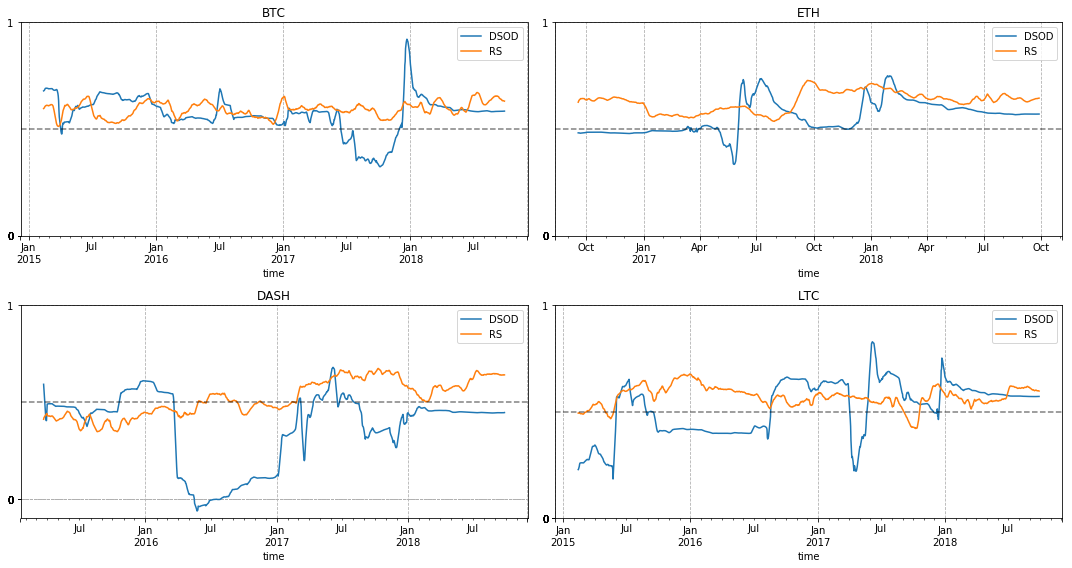

In [19]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin].rolling(10).mean().plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()    

In [20]:
roll_hurst[::20].tail()

BTC                DASH                 ETH            \
                DSOD        RS      DSOD        RS      DSOD        RS   
time                                                                     
2018-06-29  0.581680  0.648543  0.446126  0.606186  0.575801  0.670007   
2018-07-19  0.583065  0.630477  0.447796  0.634369  0.574256  0.622360   
2018-08-08  0.585923  0.628704  0.446145  0.636025  0.570969  0.652316   
2018-08-28  0.582410  0.643969  0.444729  0.642597  0.569539  0.642103   
2018-09-17  0.583420  0.638289  0.445596  0.634113  0.570348  0.640483   

                 LTC            
                DSOD        RS  
time                            
2018-06-29  0.573171  0.611192  
2018-07-19  0.572527  0.607288  
2018-08-08  0.571663  0.611281  
2018-08-28  0.571046  0.610578  
2018-09-17  0.570709  0.597666

In [21]:
roll_hurst[::20].mean()

BTC   DSOD    0.567770
      RS      0.593731
DASH  DSOD    0.374343
      RS      0.516974
ETH   DSOD    0.539447
      RS      0.627828
LTC   DSOD    0.506437
      RS      0.570406
dtype: float64

In [22]:
roll_hurst[::20].median()

BTC   DSOD    0.581680
      RS      0.594786
DASH  DSOD    0.449430
      RS      0.509296
ETH   DSOD    0.544081
      RS      0.640483
LTC   DSOD    0.554401
      RS      0.566930
dtype: float64

In [23]:
roll_hurst[::20].mean(level=0, axis=1);

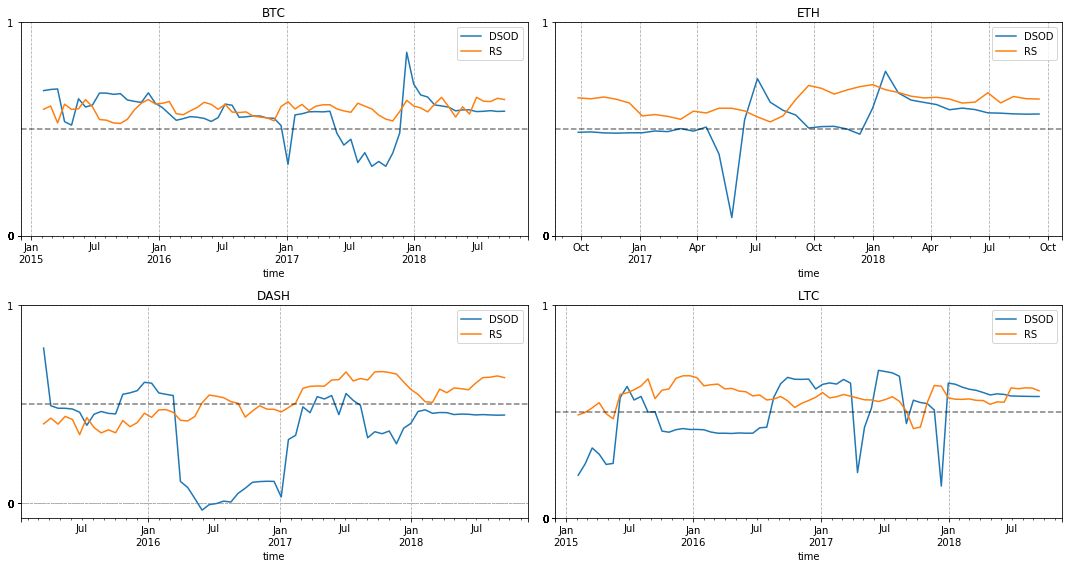

In [24]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin][::20].plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

In [25]:
# rather decimate the series we aliasing the seies.
ma_roll_hurst = roll_hurst.rolling(20).mean()
ma_roll_hurst.tail()

BTC                DASH                 ETH            \
                DSOD        RS      DSOD        RS      DSOD        RS   
time                                                                     
2018-09-24  0.582987  0.638368  0.446093  0.640869  0.569887  0.637569   
2018-09-25  0.583140  0.637581  0.446108  0.640345  0.569925  0.638464   
2018-09-26  0.583245  0.636500  0.446174  0.640678  0.570002  0.639456   
2018-09-27  0.583331  0.635657  0.446137  0.640178  0.570044  0.640341   
2018-09-28  0.583379  0.634855  0.446404  0.640575  0.570070  0.641147   

                 LTC            
                DSOD        RS  
time                            
2018-09-24  0.570611  0.598677  
2018-09-25  0.570686  0.597875  
2018-09-26  0.570755  0.598066  
2018-09-27  0.570801  0.598317  
2018-09-28  0.570847  0.598176

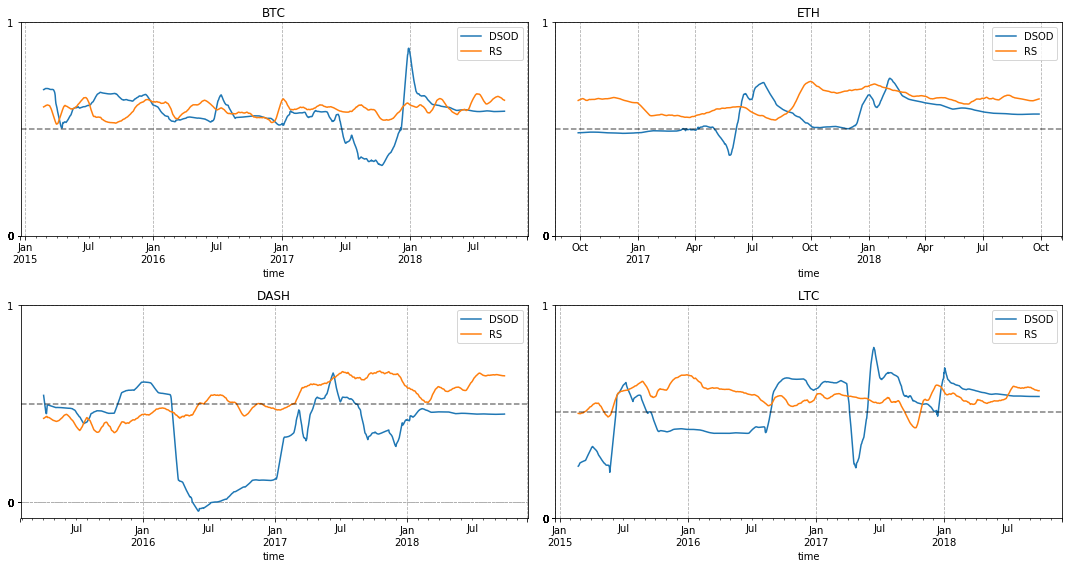

In [26]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin].rolling(20).mean().plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()    

In [27]:
roll_hurst[::30].tail()

BTC                DASH                 ETH            \
                DSOD        RS      DSOD        RS      DSOD        RS   
time                                                                     
2018-05-10  0.586899  0.571965  0.447930  0.579433  0.594356  0.633305   
2018-06-09  0.589769  0.570487  0.449430  0.572969  0.591108  0.626077   
2018-07-09  0.581554  0.679359  0.446039  0.658028  0.574387  0.616827   
2018-08-08  0.585923  0.628704  0.446145  0.636025  0.570969  0.652316   
2018-09-07  0.582473  0.653575  0.445841  0.645618  0.569661  0.626165   

                 LTC            
                DSOD        RS  
time                            
2018-05-10  0.582747  0.544384  
2018-06-09  0.580659  0.544057  
2018-07-09  0.572866  0.619976  
2018-08-08  0.571663  0.611281  
2018-09-07  0.570378  0.592763

In [28]:
roll_hurst[::30].mean()

BTC   DSOD    0.569539
      RS      0.593290
DASH  DSOD    0.364088
      RS      0.522985
ETH   DSOD    0.540603
      RS      0.627620
LTC   DSOD    0.508123
      RS      0.570126
dtype: float64

In [29]:
roll_hurst[::30].median()

BTC   DSOD    0.575880
      RS      0.592980
DASH  DSOD    0.446686
      RS      0.512747
ETH   DSOD    0.513226
      RS      0.633305
LTC   DSOD    0.567266
      RS      0.565747
dtype: float64

In [30]:
roll_hurst[::30].mean(level=0, axis=1);

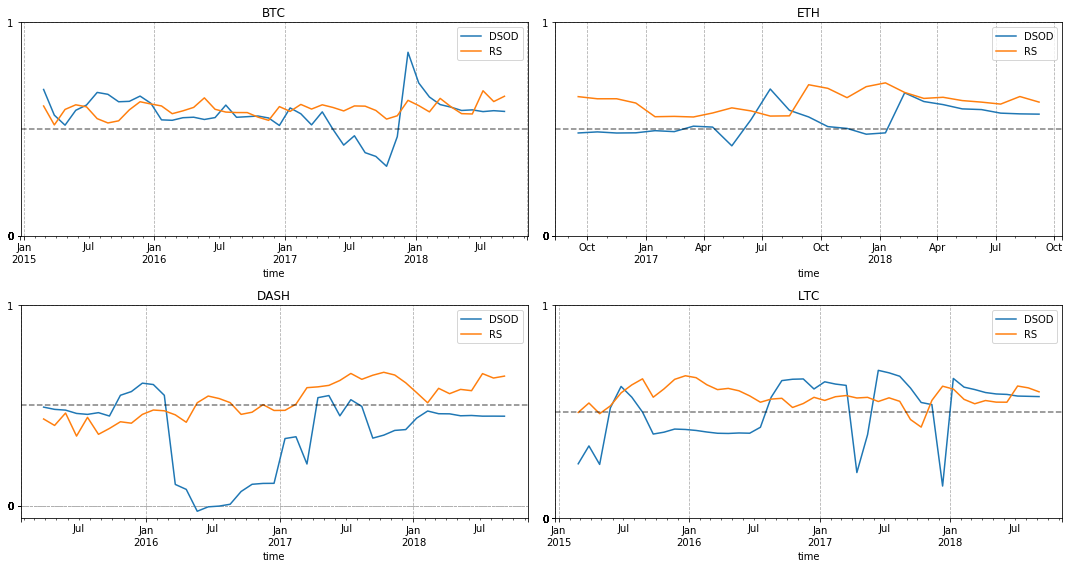

In [31]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin][::30].plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

In [32]:
# rather decimate the series we aliasing the seies.
ma_roll_hurst = roll_hurst.rolling(30).mean()
ma_roll_hurst.tail()

BTC                DASH                 ETH            \
                DSOD        RS      DSOD        RS      DSOD        RS   
time                                                                     
2018-09-24  0.582831  0.643956  0.445950  0.642705  0.569968  0.636017   
2018-09-25  0.582880  0.643026  0.445985  0.642518  0.570008  0.636147   
2018-09-26  0.582939  0.642346  0.446045  0.642441  0.570044  0.636182   
2018-09-27  0.582998  0.642104  0.446058  0.642209  0.570077  0.636241   
2018-09-28  0.583060  0.641369  0.446283  0.642245  0.570107  0.636590   

                 LTC            
                DSOD        RS  
time                            
2018-09-24  0.570799  0.601848  
2018-09-25  0.570831  0.601066  
2018-09-26  0.570854  0.600621  
2018-09-27  0.570862  0.600195  
2018-09-28  0.570878  0.599897

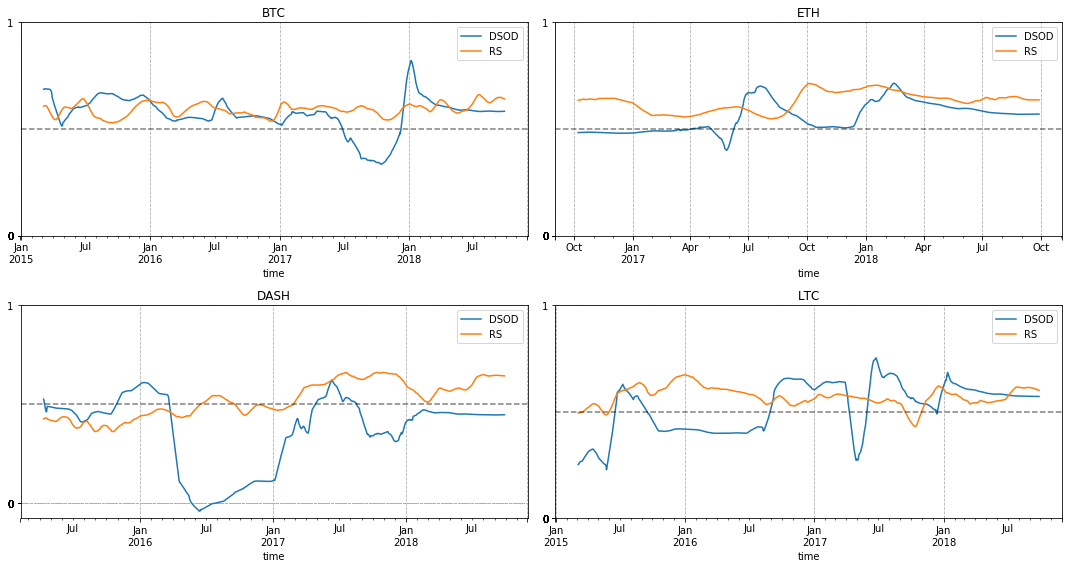

In [33]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin].rolling(30).mean().plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()    

In [34]:
roll_hurst[::50].tail()

BTC                DASH                 ETH            \
                DSOD        RS      DSOD        RS      DSOD        RS   
time                                                                     
2018-02-09  0.649988  0.580338  0.471706  0.512612  0.669606  0.671428   
2018-03-31  0.602211  0.627804  0.457758  0.581954  0.617327  0.641388   
2018-05-20  0.589775  0.604094  0.450376  0.578301  0.597975  0.621628   
2018-07-09  0.581554  0.679359  0.446039  0.658028  0.574387  0.616827   
2018-08-28  0.582410  0.643969  0.444729  0.642597  0.569539  0.642103   

                 LTC            
                DSOD        RS  
time                            
2018-02-09  0.614765  0.557416  
2018-03-31  0.593614  0.572603  
2018-05-20  0.583222  0.545738  
2018-07-09  0.572866  0.619976  
2018-08-28  0.571046  0.610578

In [35]:
roll_hurst[::50].mean()

BTC   DSOD    0.573632
      RS      0.590637
DASH  DSOD    0.366841
      RS      0.515401
ETH   DSOD    0.578073
      RS      0.625663
LTC   DSOD    0.515220
      RS      0.571219
dtype: float64

In [36]:
roll_hurst[::50].median()

BTC   DSOD    0.580353
      RS      0.592432
DASH  DSOD    0.448208
      RS      0.507950
ETH   DSOD    0.569539
      RS      0.641388
LTC   DSOD    0.571046
      RS      0.572603
dtype: float64

In [37]:
roll_hurst[::50].mean(level=0, axis=1);

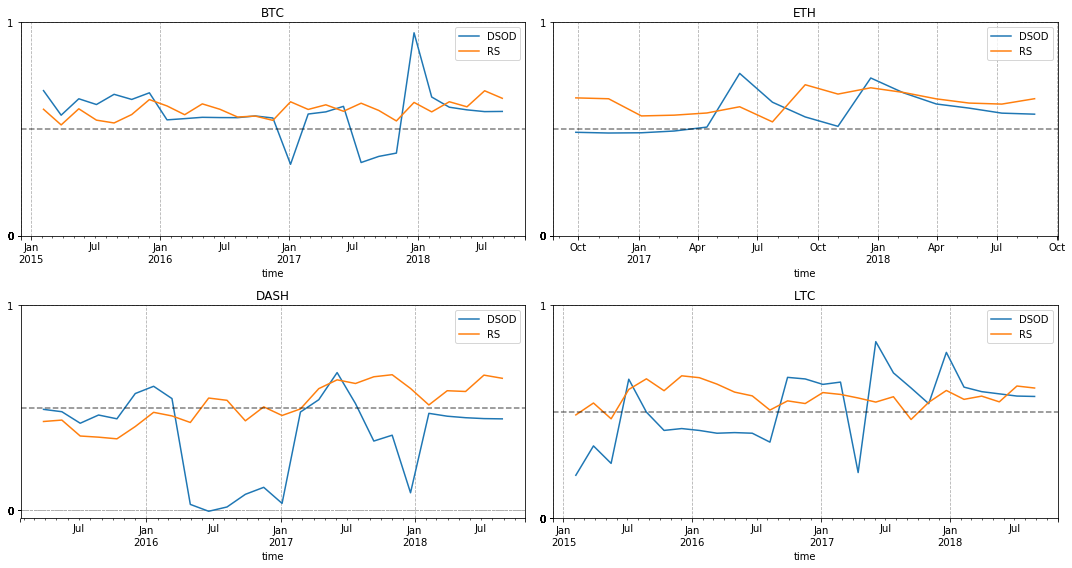

In [38]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin][::50].plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

In [39]:
# rather decimate the series we aliasing the seies.
ma_roll_hurst = roll_hurst.rolling(50).mean()
ma_roll_hurst.tail()

BTC                DASH                 ETH            \
                DSOD        RS      DSOD        RS      DSOD        RS   
time                                                                     
2018-09-24  0.582661  0.641633  0.445616  0.643709  0.569352  0.639259   
2018-09-25  0.582630  0.641837  0.445623  0.643568  0.569354  0.639222   
2018-09-26  0.582597  0.641904  0.445629  0.643748  0.569362  0.639149   
2018-09-27  0.582563  0.642064  0.445608  0.643740  0.569353  0.638980   
2018-09-28  0.582559  0.642189  0.445719  0.643530  0.569341  0.638962   

                 LTC            
                DSOD        RS  
time                            
2018-09-24  0.571073  0.606935  
2018-09-25  0.571081  0.606684  
2018-09-26  0.571084  0.606425  
2018-09-27  0.571076  0.606155  
2018-09-28  0.571064  0.605664

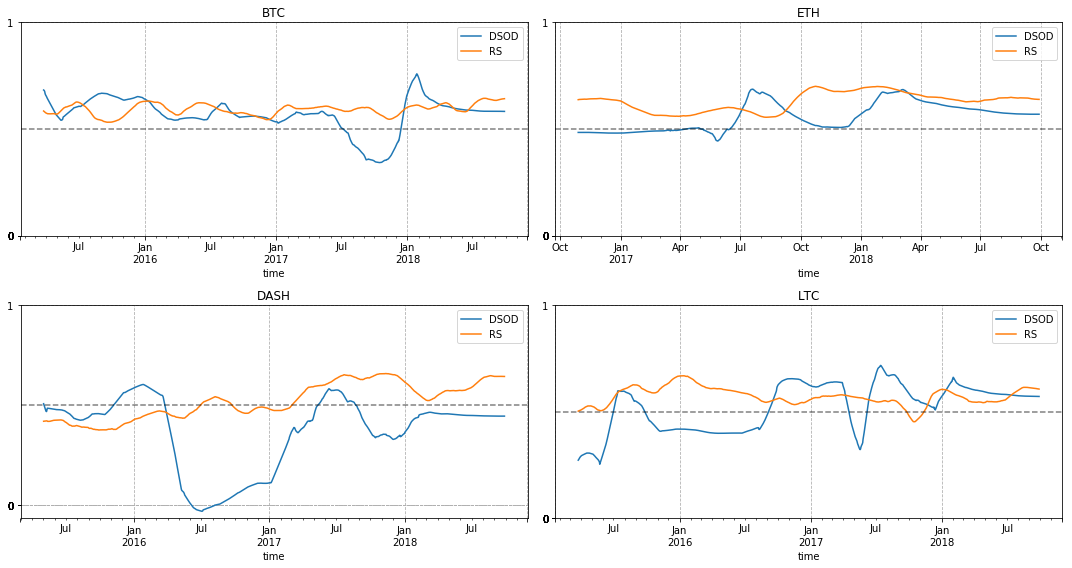

In [40]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin].rolling(50).mean().plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()    

# REFERENCES

- Caporale, G. M., Gil-Alana, L., & Plastun, A. (2017). Persistence in the Cryptocurrency Market. https://www.sciencedirect.com/science/article/pii/S0275531917309200
- H.E. Hurst, 1951, “Long-term storage of reservoirs: an experimental study,” Transactions of the American Society of Civil Engineers, Vol. 116, pp. 770-799.
- Bo Qian, Khaled Rasheed, 2004, “Hurst Exponent and financial market predictability,” IASTED conference on “Financial Engineering and Applications”(FEA 2004), pp. 203-209,
- Mandelbrot, Benoit B., 2004, “The (Mis)Behavior of Markets, A Fractal View of Risk, Ruin and Reward,” Basic Books, 2004.
